# Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random

sns.set_theme()
colors = sns.color_palette("deep")

from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), labels=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        if labels:
            label = labels[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(abscissa, H[k, :], linestyle='-', label=label, **kwargs)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalized Load')
    # ax.set_title(title)
    ax.legend(loc='upper left')
    
    return fig, ax

In [3]:
region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

daytype_order = [
    'Working day',
    'Saturday',
    'Holiday'
]

# Load selected model and input data

In [6]:
method = 'WHopt_3comp_10000runs'
data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)

W = data['W']
H = data['H']

In [5]:
# HOTFIX: reordering components for plotting
reordering = np.array([0, 2, 1])
W = W[:, reordering]
H = H[reordering, :]

(0.0, 0.06)

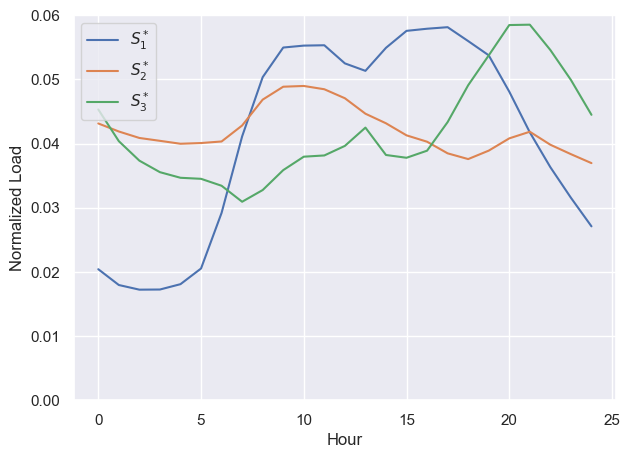

In [7]:
fig, ax = plot_components(H, labels=['$S_1^*$', '$S_2^*$', '$S_3^*$'], marker=None, linewidth=1.5, figsize=(7, 5))
ax.set_ylim((0,0.06))

In [8]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11646


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,980.735,926.445,845.014,756.975,688.183,601.762,Calabria,2021,01,Working day


# Reconstruct the load per component

In [9]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

method = 'WHopt_3comp_10000runs'
curves_comp = {}

for k in range(H.shape[0]):

    W_k = W[:, k]
    H_k = H[k, :]

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the 25th point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=range(H_k.shape[0]-1), index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,date,region,year,month,daytype
Calabria_2021-01-02_Saturday,106.492613,93.652551,89.872335,89.990711,94.339259,107.065320,152.262029,214.426799,262.555900,286.648230,...,280.334621,250.803983,217.725395,189.392790,164.560525,2021-01-02,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,130.591441,114.845727,110.210065,110.355229,115.687834,131.293750,186.718283,262.950677,321.971191,351.515514,...,343.773161,307.559865,266.995732,232.251578,201.799876,2021-01-03,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,212.208946,186.622420,179.089545,179.325433,187.990830,213.350186,303.414142,427.290530,523.197895,571.206935,...,558.625739,499.779728,433.863678,377.404998,327.921484,2021-01-04,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,152.448022,134.067010,128.655494,128.824954,135.050057,153.267874,217.968595,306.959708,375.858256,410.347297,...,401.309137,359.034963,311.681769,271.122621,235.574336,2021-01-05,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,148.855512,130.907657,125.623666,125.789132,131.867538,149.656043,212.832061,299.726056,367.000976,400.677267,...,391.852096,350.574132,304.336839,264.733486,230.022914,2021-01-06,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-26_Holiday,219.213889,192.782761,185.001228,185.244903,194.196342,220.392801,313.429737,441.395241,540.468475,590.062276,...,577.065779,516.277281,448.185366,389.863005,338.746057,2022-12-26,South,2022,12,Holiday
South_2022-12-27_Working day,597.700603,525.634452,504.417607,505.082004,529.488669,600.914981,854.586101,1203.492181,1473.621650,1608.842301,...,1573.406528,1407.662824,1222.005889,1062.986265,923.612657,2022-12-27,South,2022,12,Working day
South_2022-12-28_Working day,816.205322,717.793549,688.820345,689.727629,723.056774,820.594799,1167.001875,1643.459483,2012.341678,2196.995691,...,2148.605466,1922.269919,1668.741350,1451.588041,1261.262851,2022-12-28,South,2022,12,Working day
South_2022-12-29_Working day,405.547470,356.649669,342.253770,342.704571,359.264805,407.728467,579.847552,816.584770,999.871055,1091.619989,...,1067.576365,955.117152,829.146557,721.249717,626.682949,2022-12-29,South,2022,12,Working day


In [10]:
info_cols = ['region', 'year', 'month', 'daytype']

comp_df = curves_comp['Component 1'].melt(id_vars=['date']+info_cols, var_name='hour', value_name='Component 1')

for k in range(1, H.shape[0]):
    comp = f'Component {k + 1}'
    comp_df[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')['load']

comp_df['date'] = pd.to_datetime(comp_df['date'])
comp_df['datetime'] = comp_df['date'] + pd.to_timedelta(comp_df['hour'], unit='h')
comp_df.set_index('datetime', inplace=True)
comp_df.sort_values(['region', 'date', 'hour'], inplace=True)
comp_df

,date,region,year,month,daytype,hour,Component 1,Component 2,Component 3
datetime,,,,,,,,,
2021-01-02 00:00:00,2021-01-02,Calabria,2021,01,Saturday,0,106.492613,50.159472,389.433707
2021-01-02 01:00:00,2021-01-02,Calabria,2021,01,Saturday,1,93.652551,48.700652,346.961239
2021-01-02 02:00:00,2021-01-02,Calabria,2021,01,Saturday,2,89.872335,47.528678,320.867592
2021-01-02 03:00:00,2021-01-02,Calabria,2021,01,Saturday,3,89.990711,47.010538,305.443063
2021-01-02 04:00:00,2021-01-02,Calabria,2021,01,Saturday,4,94.339259,46.480664,297.936362
...,...,...,...,...,...,...,...,...,...
2022-12-30 19:00:00,2022-12-30,South,2022,12,Working day,19,1260.956863,0.003270,1267.232962
2022-12-30 20:00:00,2022-12-30,South,2022,12,Working day,20,1128.126818,0.003431,1378.874897
2022-12-30 21:00:00,2022-12-30,South,2022,12,Working day,21,979.337944,0.003518,1380.224444


# Up-sample

In [11]:
day_df = comp_df.groupby(['region', 'year', 'month', 'date', 'daytype'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
day_df

,region,year,month,date,daytype,Component 1,Component 2,Component 3
0,Calabria,2021,01,2021-01-02,Saturday,5201.944289,1.180161e+03,8606.858307
1,Calabria,2021,01,2021-01-03,Holiday,6379.122299,3.460965e+00,8603.348085
2,Calabria,2021,01,2021-01-04,Working day,10365.968932,9.174237e+02,6266.065145
3,Calabria,2021,01,2021-01-05,Working day,7446.771171,5.581219e+03,4174.955172
4,Calabria,2021,01,2021-01-06,Holiday,7271.284446,1.467848e+03,6821.934461
...,...,...,...,...,...,...,...,...
11641,South,2022,12,2022-12-26,Holiday,10708.145940,6.005484e-05,23341.186611
11642,South,2022,12,2022-12-27,Working day,29196.440555,2.621387e+02,18875.254119
11643,South,2022,12,2022-12-28,Working day,39869.945024,4.640666e-19,14691.496188
11644,South,2022,12,2022-12-29,Working day,19810.156712,1.443245e+04,14904.473317


In [12]:
month_df = comp_df.groupby(['region', 'year', 'month'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
month_df

,region,year,month,Component 1,Component 2,Component 3
0,Calabria,2021,01,243445.725080,44879.958348,215479.446858
1,Calabria,2021,02,221408.073096,47325.907136,197655.295854
2,Calabria,2021,03,197214.512598,63376.104745,217126.042937
3,Calabria,2021,04,143809.353012,89905.006255,195244.970954
4,Calabria,2021,05,110123.300726,132503.514206,173598.343509
...,...,...,...,...,...,...
379,South,2022,08,620767.563485,769052.081140,699288.913895
380,South,2022,09,485509.875375,605228.234918,632837.381051
381,South,2022,10,477148.205384,518449.785470,624224.043673
382,South,2022,11,676474.433585,313635.189442,602060.008102


In [13]:
year_df = comp_df.groupby(['region', 'year'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
year_df

,region,year,Component 1,Component 2,Component 3
0,Calabria,2021,2.352554e+06,1.398016e+06,2.843690e+06
1,Calabria,2022,2.198806e+06,1.865509e+06,2.471471e+06
2,Centre.North,2018,1.463275e+07,1.207540e+07,7.524319e+06
3,Centre.North,2019,1.438362e+07,1.172144e+07,7.898212e+06
4,Centre.North,2020,1.255579e+07,1.124577e+07,7.307644e+06
5,Centre.North,2021,1.231419e+07,1.036984e+07,5.116426e+06
6,Centre.North,2022,1.263249e+07,1.072924e+07,4.366217e+06
7,Centre.South,2018,1.887424e+07,9.725542e+06,1.798478e+07
8,Centre.South,2019,1.922892e+07,9.522757e+06,1.881985e+07
9,Centre.South,2020,1.748870e+07,8.916899e+06,1.877726e+07


# Analysis

In [14]:
component = 'Component 1'
region = 'North'
df_plot = day_df[day_df.region == region]

fig = px.line(
    df_plot,
    x = 'date',
    y = component,
    title = f'Total Load Evolution of {component} for region {region} [MW]',
    height = 700,
    hover_data={'date': '|%B %d, %Y', component: True, 'daytype': True}
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Load')
fig.show()

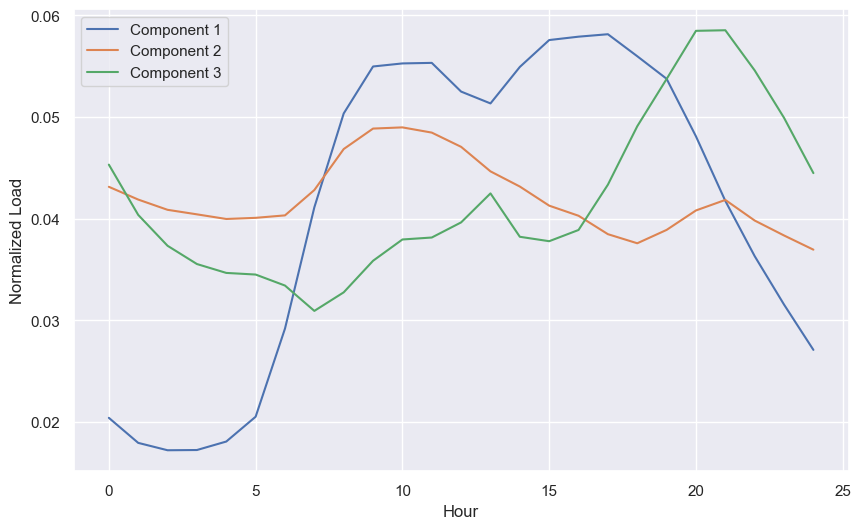

In [15]:
fig, ax = plot_components(H)

In [16]:
component = 'Component 3'
# region = 'North'

fig = px.bar(
    month_df.groupby(['year', 'month'], as_index=False)[component].sum(),
    x = 'month',
    y = component,
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [17]:
day_df.groupby(['daytype'])[[f'Component {k+1}' for k in range(H.shape[0])]].mean()

,Component 1,Component 2,Component 3
daytype,,,
Holiday,18924.667719,34552.077868,52827.315247
Saturday,24620.047203,61263.547070,35444.268806
Working day,66243.109335,50656.389134,27626.445324


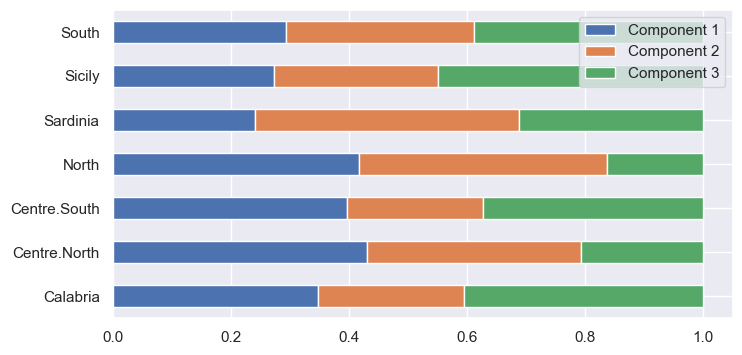

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_plot = year_df.groupby('region').sum().drop('year', axis=1)
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)
df_plot.plot.barh(stacked=True, ax=ax)
ax = ax.set_ylabel("")

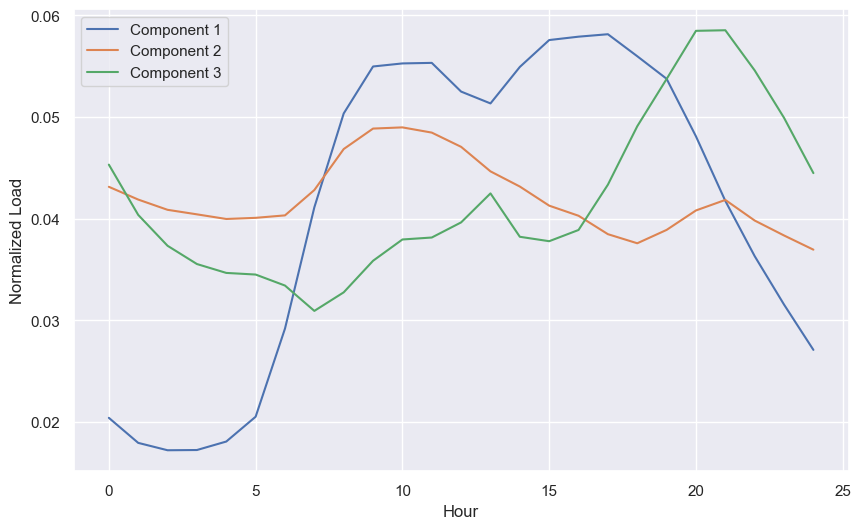

In [19]:
fig, ax = plot_components(H)

In [20]:
year_df.groupby('region').sum().drop('year', axis=1)

,Component 1,Component 2,Component 3
region,,,
Calabria,4.551361e+06,3.263525e+06,5.315161e+06
Centre.North,6.651884e+07,5.614168e+07,3.221282e+07
Centre.South,9.757331e+07,5.704139e+07,9.200407e+07
North,3.694141e+08,3.710642e+08,1.453428e+08
Sardinia,1.076026e+07,1.998526e+07,1.399234e+07
Sicily,2.578388e+07,2.633689e+07,4.242165e+07
South,3.893656e+07,4.217238e+07,5.149842e+07


In [21]:
month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)

,year,month,Component 1,Component 2,Component 3
0,2018,01,1.311358e+07,7.817412e+06,6.531706e+06
1,2018,02,1.202838e+07,8.390145e+06,5.652766e+06
2,2018,03,1.146441e+07,9.930960e+06,5.743506e+06
3,2018,04,8.344941e+06,1.010929e+07,6.056736e+06
4,2018,05,9.723173e+06,1.059510e+07,5.948824e+06
5,2018,06,9.870903e+06,1.108864e+07,6.050135e+06
6,2018,07,1.113265e+07,1.108263e+07,7.976715e+06
7,2018,08,8.193125e+06,9.194747e+06,8.958472e+06
8,2018,09,9.487259e+06,1.063408e+07,6.725881e+06
9,2018,10,1.055201e+07,1.013104e+07,5.881484e+06


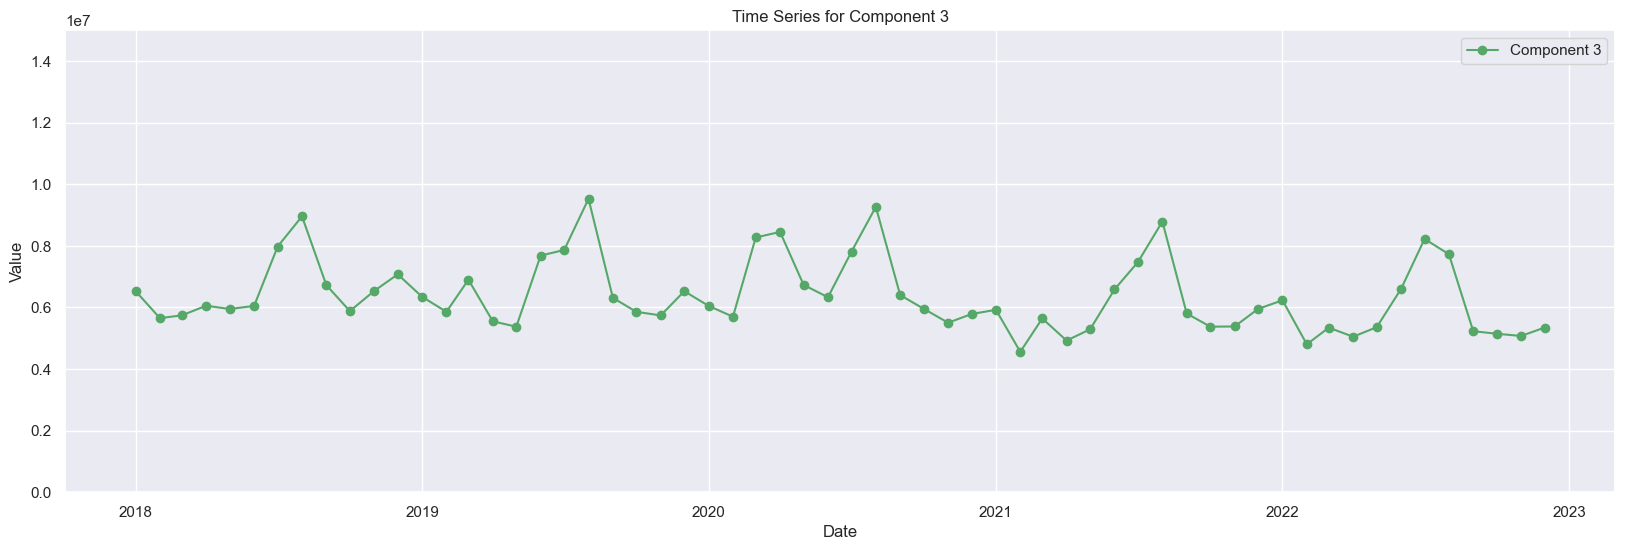

In [23]:
# Convert year and month to datetime
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot['date'] = pd.to_datetime(df_plot['year'].astype(str) + '-' + df_plot['month'], format='%Y-%m')

# Drop year and month columns
df_plot.drop(columns=['year', 'month'], inplace=True)

# Set the 'date' column as the index
df_plot.set_index('date', inplace=True)

plt.figure(figsize=(20, 6))

# Plot each component as a time series
k = 2
col = f'Component {k+1}'
plt.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Time Series for {col}')
plt.legend()
plt.ylim((0, 1.5e7))

# Show plot
plt.show()

In [24]:
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot.head()

,year,month,Component 1,Component 2,Component 3
0,2018,01,1.311358e+07,7.817412e+06,6.531706e+06
1,2018,02,1.202838e+07,8.390145e+06,5.652766e+06
2,2018,03,1.146441e+07,9.930960e+06,5.743506e+06
3,2018,04,8.344941e+06,1.010929e+07,6.056736e+06
4,2018,05,9.723173e+06,1.059510e+07,5.948824e+06


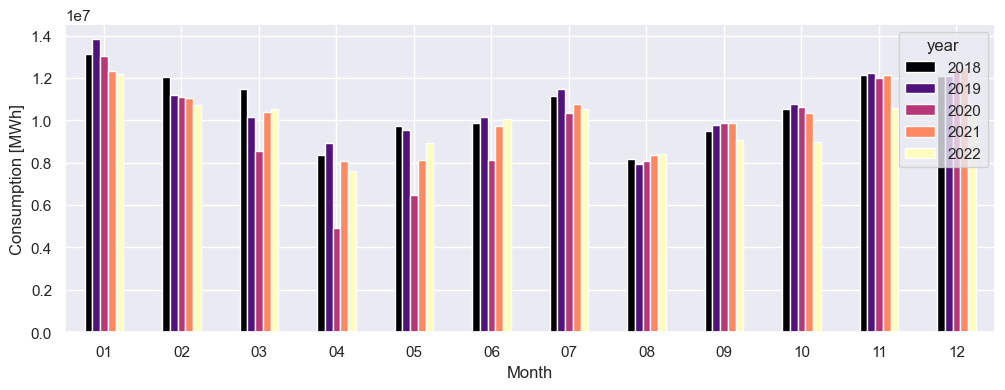

In [25]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 1').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

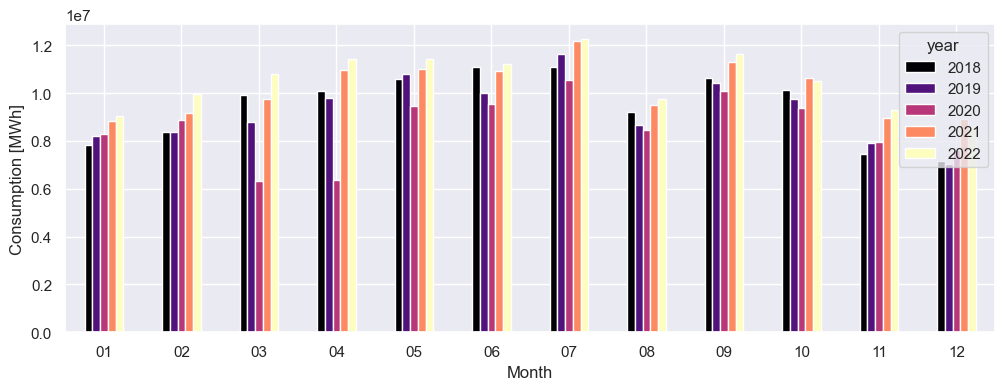

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 2').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

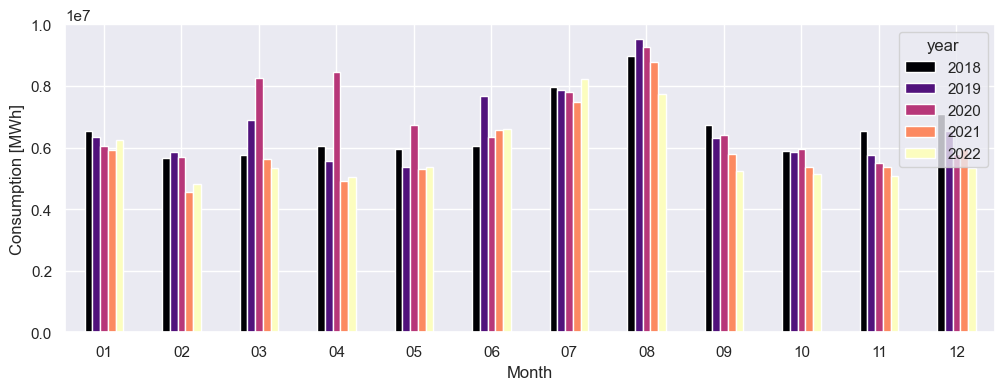

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 3').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')